## Image segmentation with CamVid

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [0]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_02160.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_01920.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_07410.png')]

In [0]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_08025_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_010290_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f03540_P.png')]

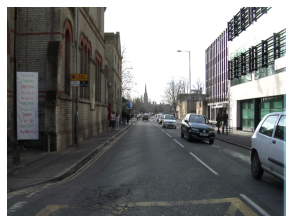

In [0]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

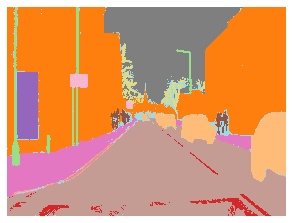

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [0]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

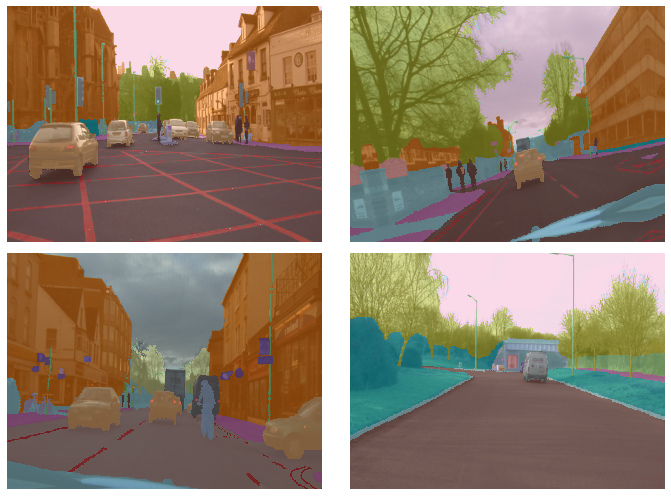

In [0]:
data.show_batch(2, figsize=(10,7))

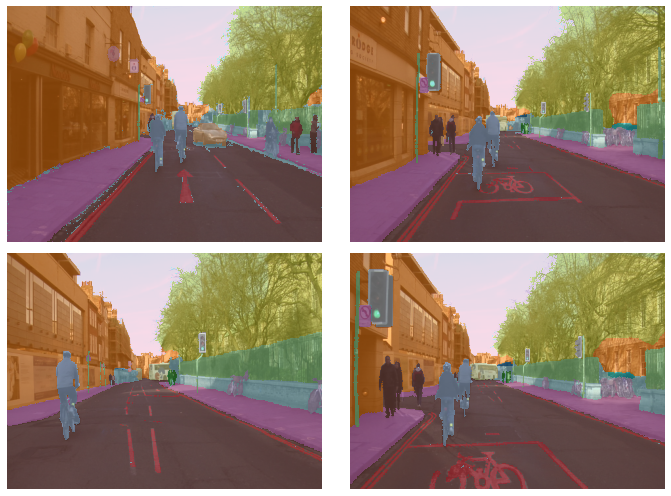

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


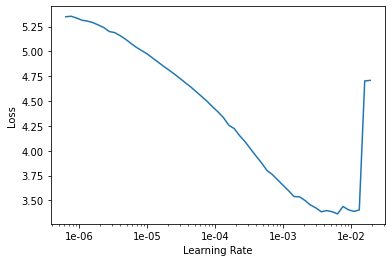

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.006297,0.765746,0.809078,01:40
1,0.717391,0.597060,0.846813,01:40
2,0.651406,0.613986,0.847347,01:40
3,0.625142,0.483272,0.865910,01:39
4,0.604862,0.511893,0.860877,01:38
5,0.583126,0.449084,0.875658,01:38
6,0.578490,0.475097,0.886129,01:37
7,0.564463,0.625078,0.842934,01:37
8,0.513803,0.393519,0.892237,01:36
9,0.428130,0.334778,0.901869,01:36


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

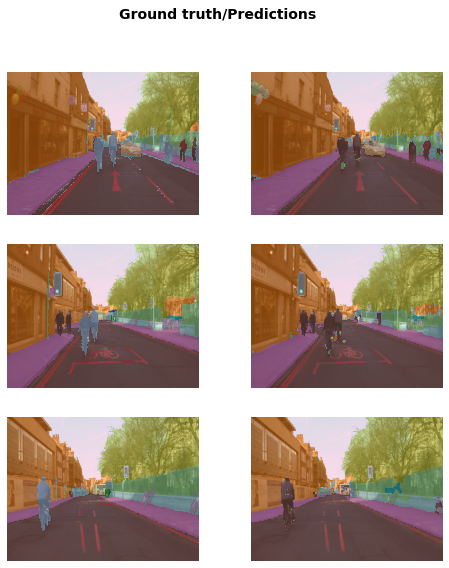

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.393442,0.324591,0.903186,01:43
1,0.371953,0.318751,0.903471,01:42
2,0.371015,0.314269,0.903015,01:43
3,0.362427,0.318917,0.902660,01:43
4,0.351833,0.306636,0.917074,01:43
5,0.342055,0.296682,0.913888,01:43
6,0.324475,0.296385,0.911137,01:43
7,0.341431,0.295842,0.916778,01:43
8,0.315655,0.290138,0.912314,01:43
9,0.312259,0.287005,0.921290,01:43


In [0]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 7074MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


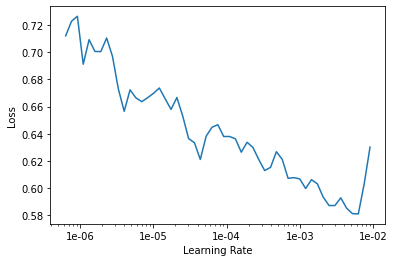

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.405221,0.325472,0.911355,06:46
1,0.377446,0.317112,0.915620,06:46
2,0.379309,0.296768,0.918272,06:47
3,0.376980,0.349142,0.904836,06:46
4,0.389648,0.333624,0.908205,06:45
5,0.408980,0.335415,0.906792,06:44
6,0.367975,0.296529,0.919453,06:45
7,0.362271,0.318116,0.925587,06:44
8,0.307246,0.270493,0.929309,06:44
9,0.273111,0.251830,0.932614,06:45


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.246448,0.261852,0.931367,07:08
1,0.226213,0.272143,0.928322,07:07
2,0.245073,0.255844,0.931663,07:07
3,0.238528,0.245083,0.933418,07:07
4,0.214341,0.254534,0.933663,07:07
5,0.220965,0.256884,0.932361,07:07
6,0.218565,0.255367,0.932572,07:07
7,0.215020,0.251066,0.934033,07:07
8,0.205747,0.256681,0.931431,07:07
9,0.196433,0.258194,0.932125,07:07


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

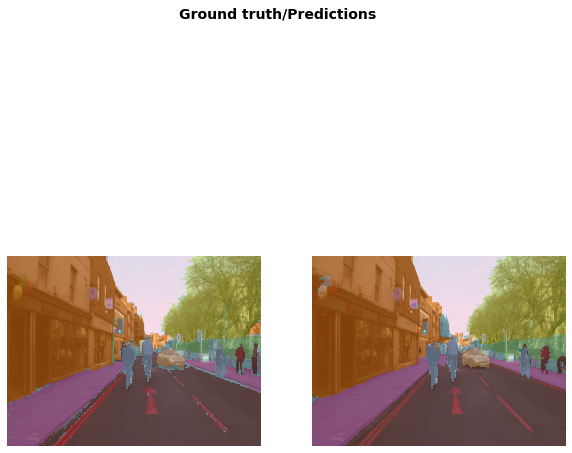

In [0]:
learn.show_results(rows=3, figsize=(10,10))

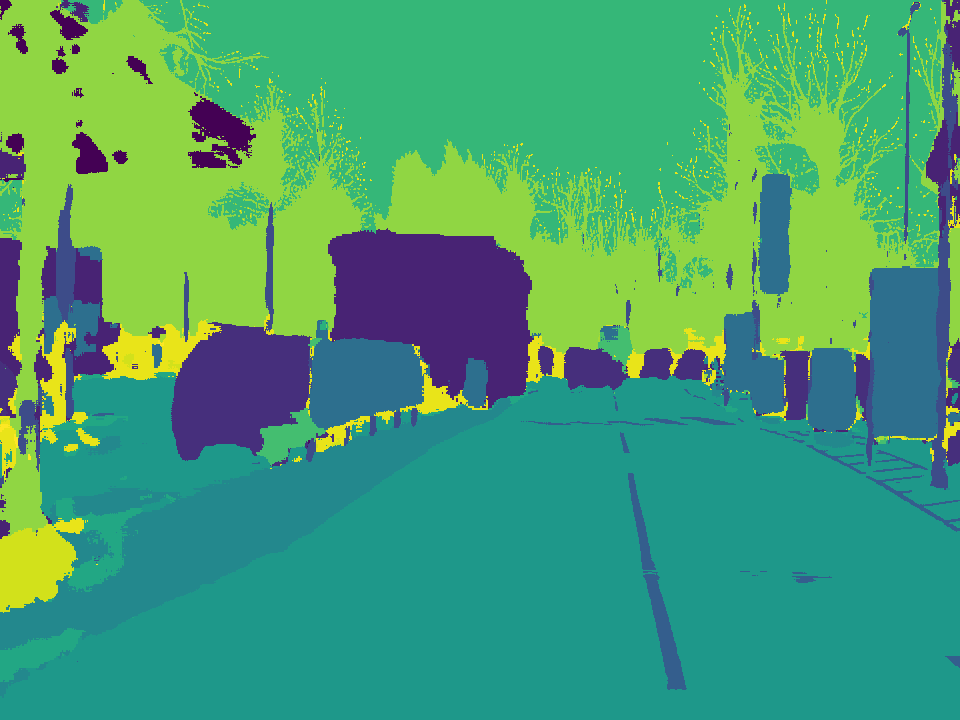

In [0]:
img = open_image('ll.png')
x = learn.predict(img)
x[0]

## fin

In [0]:
learn.export()

In [0]:
shutil.move('/root/.fastai/data/camvid/images/export.pkl', '/export.pkl')

'/export.pkl'